# Simulación y reconstrucción de lente extensa
En este *notebook* se llevará a cabo la simulación de una imagen de una galaxia *lensada* para posteriormente, mediante un algoritmo de reconstrucción, recuperar los parámetros de la lente empleada. 

El algoritmo está inspirado del libro Meneghetti, M. [*Introduction to Gravitational Lensing: With Python Examples*](https://doi.org/10.1007/978-3-030-73582-1). También se hace uso de la librería `lenstronomy` ([Birrer, S. et al.](https://doi.org/10.21105/joss.03283)).

Importamos las funciones necesarias

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import param_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Util import util
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.Data.psf import PSF
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import FlatLambdaCDM
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

## 1. Simulación de la galaxia lensada
En este apartado se simulará la ímagen de una galaxia con cuásar en la parte central lensada por una lente tipo *Sèrsic*.
### 1.1 Definimos parámetros de la foto
En `lenstronomy` hay una forma para simular de manera más o menos realista una foto; mediante la clase `PSF` se simulan efectos de dispersión de punto; también se puede simular ruido gaussiano de fondo y ruido de poisson.

In [3]:
# Parámetros de la foto
background_rms = 0.5 # ruido de fondo por píxel
exp_time = 100 # tiempo de exposición
numPix = 200 # numero de píxeles de la imagen
deltaPix = 0.05 # tamaño de pixel en arcosegundos

# Especificamos efecto de dispersión de punto
fwhm = 0.1 
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix,
exp_time,
background_rms)
data_class = ImageData(**kwargs_data)
kwargs_psf = {"psf_type": "GAUSSIAN",
"fwhm": fwhm,
"pixel_size": deltaPix,
"truncation": 5}
psf_class = PSF(**kwargs_psf)

### 1.2 Definimos la lente
Usamos una lente de tipo *Sérsic* elíptica, definida en [Cardone, V. F.](https://doi.org/10.1051/0004-6361:20031696). La convergencia se expresa

$$\kappa(R)=\kappa_{eff}exp[-b_n(R/R_{Sersic})^{\frac{1}{n}}],$$

donde, $b_n\approx 1.999n-0.327$. Se simula una lente de masa $M=10^{12}M_\odot$, fijando primeramente los parámetros $R_{Sersic},n,e_1,e_2$ y mediante la función definida `sersic_m_star2k_eff` conseguimos el parámetro $\kappa_{eff}$. Los parámetros escogidos son:

$$ \{\kappa_{eff}=3.57,R_{Sersic}=0.5'',n=4,e_1=0.1,e_2=0.1\}$$

In [4]:
#Parámetros del sistema
zl=0.3 # redshift de la lente
zs=1.5 # redshift de la fuente
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.05) #definimos el modelo cosmológico
lens_cosmo = LensCosmo(z_lens=zl, z_source=zs, cosmo=cosmo)

#Parámetros de la lente
R_sersic = 0.5 
n_sersic = 4
m_star=10**(12) #Masa en masas solares
k_eff = lens_cosmo.sersic_m_star2k_eff(m_star=m_star, R_sersic=R_sersic, 
                                       n_sersic=n_sersic) 

#Definimos la lente Sérsic elípitica
lens_model_list = ["SERSIC_ELLIPSE_POTENTIAL"]
lens_model_class = LensModel(lens_model_list=lens_model_list)
kwargs_sersiclens = {"k_eff": k_eff,'R_sersic':R_sersic,'n_sersic':n_sersic,
"center_x": 0,
"center_y":0,'e1':0.1,'e2':0.1}
kwargs_lens = [kwargs_sersiclens]

### 1.3 Perfiles de luminosidad de la lente y de la fuente
Mediante la clase `LightModel` de lenstronomy se simulará un perfil de luminosidad de tipo *Sèrsic* (típico para simular galaxias):

$$I(R)=I_0exp(-b_n(R/R_{Sersic})^{\frac{1}{n}})$$

Para la lente se escogen los siguientes parámetros

$$ \{amp=400,R_{Sersic}=2'',n=4,e_1=0.1,e_2=0.1,x=0'',y=0''\} $$

Para la fuente se escogen:

$$\{amp=400,R_{Sersic}=2.5'',n=3,e_1=0.1,e_2=0.1,x=0.7'',y=0''\}$$

Obsérvese que la fuente lente están desalineadas pues se ha colocado la lente en la posición $(0'',0'')$ y la fuente en (0.7'',0).

In [5]:
# Perfil de luminosidad para la lente
lens_light_model_list = ["SERSIC_ELLIPSE"]
kwargs_sersic = {"amp":400, # Flujo de la lente (unidades arbitrarias)
"R_sersic": 2 ,# radio efectivo
"n_sersic": 4, # índice sersic
"center_x": 0., # coordenada-x
"center_y": 0., # coordenada-y
"e1": 0.1,
"e2": 0.1}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)


# Perfil de luminosidad para la fuente
source_model_list = ["SERSIC_ELLIPSE"]
ra_source, dec_source = 0.7,0 #Posicion de la fuente
kwargs_sersic_ellipse = {"amp": 400.,
"R_sersic": 2.5,
"n_sersic": 3,
"center_x": ra_source,
"center_y": dec_source,
"e1": 0.1,
"e2": 0.3}
kwargs_source = [kwargs_sersic_ellipse]
source_model_class = LightModel(light_model_list=source_model_list)

### 1.4 Resolvemos la ecuación de la lente
Al centrar la galaxia fuente en la posición $(0.7'',0)$ el cuásar (que se situa en el centro de la galaxia) estará en esa posición; para conseguir las imágenes del cuásar resolvemos la ecuación de la lente para ese punto.

In [6]:
# Resolvemos la ecuación de la lente para determinar
# posiciones del cuásar. Usamos LensEquationSolver de lenstronomy.
lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.image_position_from_source(ra_source,dec_source,
kwargs_lens, min_distance=deltaPix,
search_window=numPix * deltaPix,
precision_limit=1e-10, num_iter_max=100,
arrival_time_sort=True,
initial_guess_cut=True,
verbose=False,
x_center=0,
y_center=0,
num_random=0,
non_linear=False,
magnification_limit=None)

### 1.5 Simulamos la imagen sin lensar
Para simular la imagen sin lensar primero usamos la clase `Point_Source` para simular el cuásar. Los parámetros escogidos son


$$ \{amp=100000,x=0.7'',y=0\} $$

Para crear la imagen se usa la clase `ImageModel`, mediante `add_poisson` añadimos ruido de poisson y mediante `add_background` añadimos ruido de fondo. 

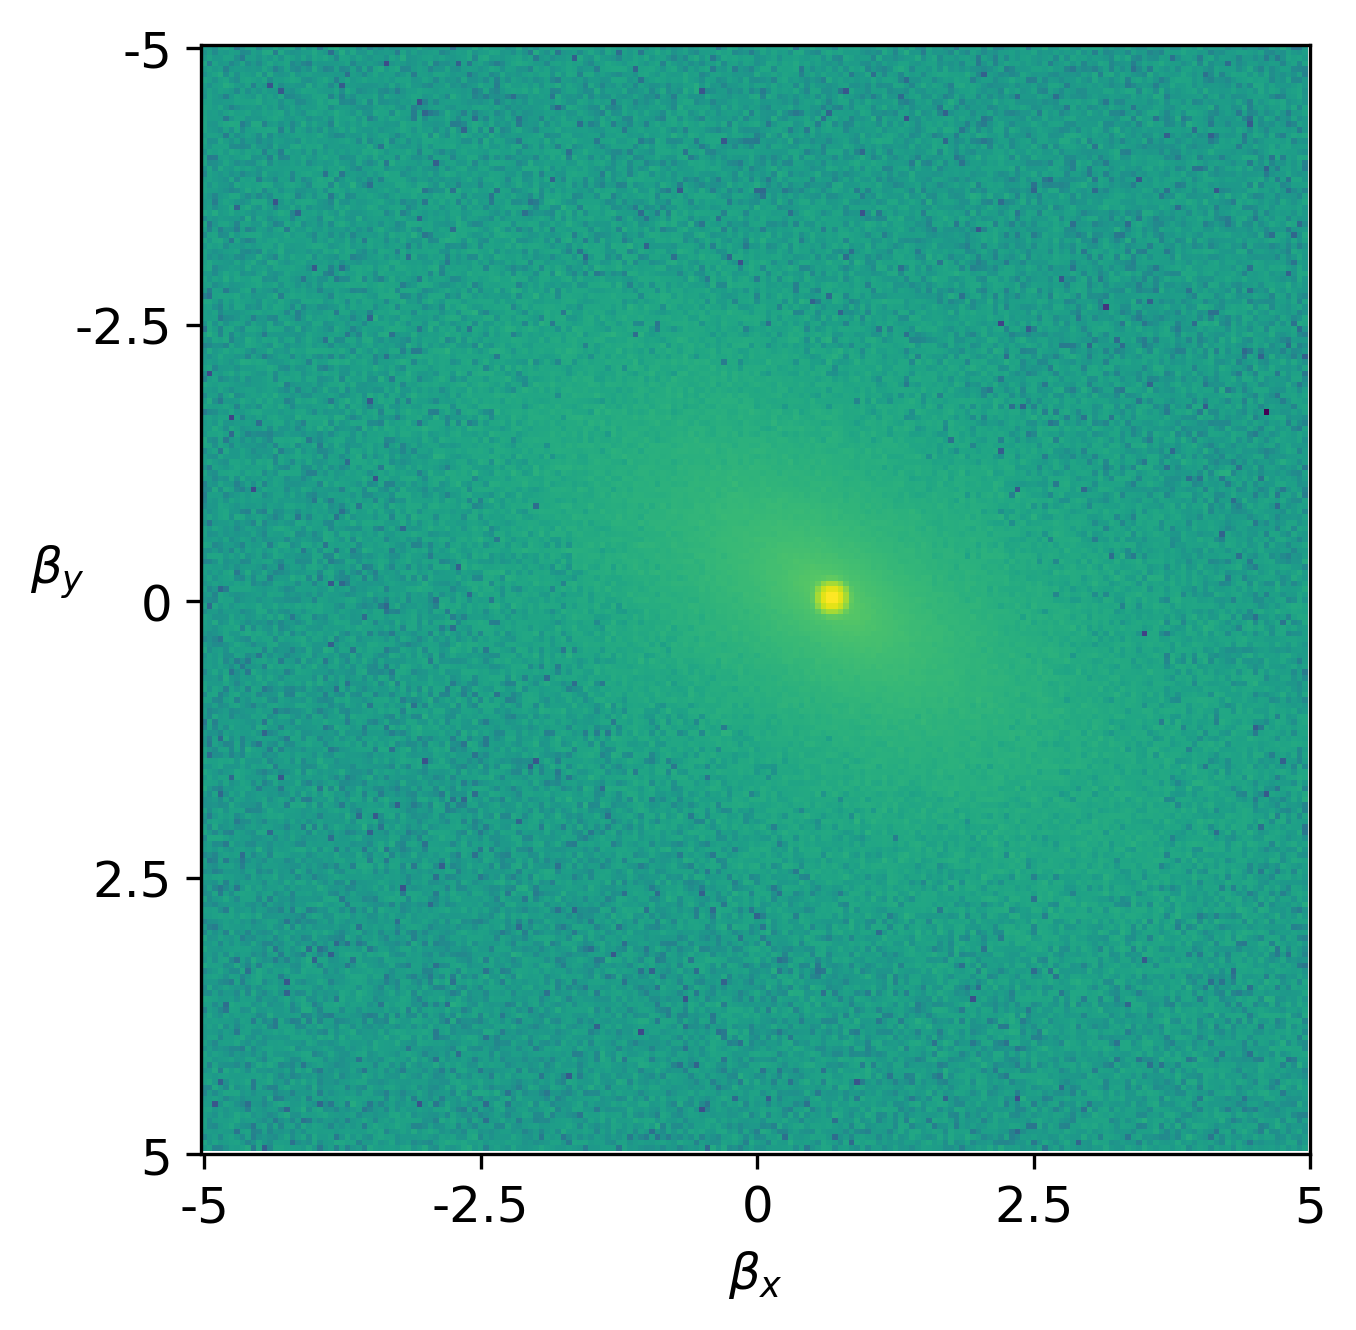

In [7]:
# Creamos las imágenes simuladas lensadas y sin lensar
kwargs_numerics = {"supersampling_factor": 1,
"supersampling_convolution": False}


# Usamos clase Point_Source para el cuasar
# Posición del cuásar en el plano de la fuente
kwargs_ps = [{"ra_image": [ra_source],
"dec_image": [dec_source],
"point_amp": [100000]}]
point_source_list2 = ["UNLENSED"]
point_source_class2 =PointSource(point_source_type_list=point_source_list2,
fixed_magnification_list=[False])

# Generamos imagen sin lensar
imageModel2 = ImageModel(data_class, psf_class,lens_light_model_class=source_model_class,
                         point_source_class=point_source_class2,
                         kwargs_numerics=kwargs_numerics)
image2 = imageModel2.image(kwargs_lens_light=kwargs_source,
                            kwargs_ps=kwargs_ps)
poisson = image_util.add_poisson(image2, exp_time=exp_time) # ruido poisson
bkg = image_util.add_background(image2, sigma_bkd=background_rms) # ruido de fondo
image2 = image2 + bkg + poisson # imagen sin lensar

# Graficamos en escala logarítmica
data=np.log10(np.abs(image2))
img=plt.imshow(data,cmap='viridis',vmin=data.min(),vmax=data.max())
plt.xlabel(r'$\beta_x$')
plt.ylabel(r'$\beta_y$ ',rotation=0)
plt.xticks([0,50,100,150,200],[-5,-2.5,0,2.5,5])
plt.yticks([0,50,100,150,200],[-5,-2.5,0,2.5,5])
plt.show()


### 1.6 Simulamos imagen lensada
Introduciendo la lente en la clase `ImageModel` y las soluciones de la ecuación de la lente conseguimos la imagen de la galaxia y el cuásar lensado.

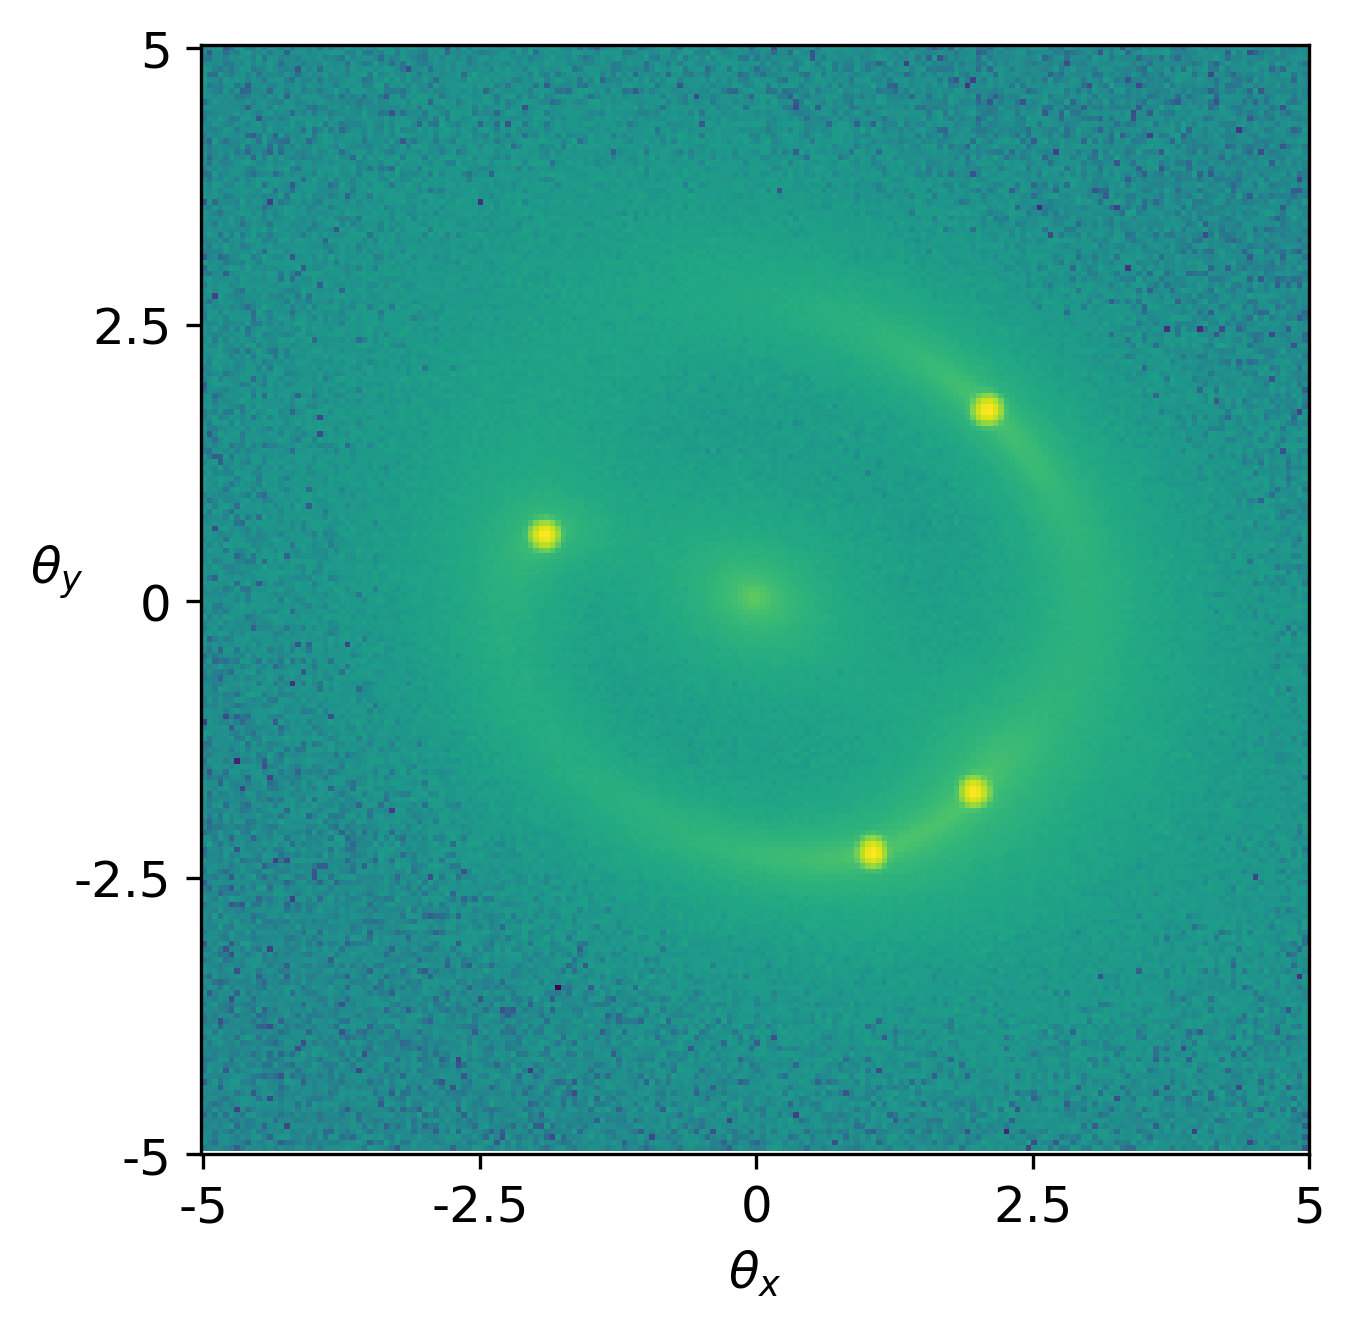

In [8]:
# Usamos clase Point_Source para el cuasar
# Posición de las imágenes del cuasar
kwargs_ps = [{"ra_image": x_image,
"dec_image": y_image,
"point_amp": 100000}] # Imponemos gran luminosidad del cuásar
point_source_list = ["LENSED_POSITION"]
point_source_class =PointSource(point_source_type_list=point_source_list,
fixed_magnification_list=[False])

# Incluimos los efectos de psf, de ruido etc.
imageModel = ImageModel(data_class, psf_class, lens_model_class,source_model_class,
                        lens_light_model_class,point_source_class,
                        kwargs_numerics=kwargs_numerics)

# La imagen lensada
image_sim = imageModel.image(kwargs_lens, kwargs_source,kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson

# Graficamos
data=np.log10(np.abs(image_sim))
img=plt.imshow(data,cmap='viridis',vmin=data.min(),vmax=data.max())
plt.xlabel(r'$\theta_x$')
plt.ylabel(r'$\theta_y$ ',rotation=0)
plt.xticks([0,50,100,150,200],[-5,-2.5,0,2.5,5])
plt.yticks([0,50,100,150,200],[5,2.5,0,-2.5,-5])
plt.show()


## 2. Algoritmo de reconstrucción
En este apartado se usa la imagen lensada simulada para recuperar los parámetros de la lente empleados. Como única restricción escogemos las imágenes del cuásar lensado.

<div class="alert alert-warning">

**Attention:** Este algoritmo es ineficiente por tanto es mejor ejecutarlo en Python directamente mediante el archivo [Reconstrucción.py](./Reconstruccion.py).
</div>

Se hace uso de la librería `lmfit` [(Neville, M. et al.)](https://doi.org/10.5281/zenodo.11813)

### 2.1 Recogemos las imágenes del cuásar
Añadimos un error gaussiana simulando un error en la medición.

In [9]:
# Añadimos error gaussiano a las "observaciones"
mu, sigma = 0, 0.015 # media y desvaición estándar
s1 = np.random.normal(mu, sigma, len(x_image))
s2 = np.random.normal(mu, sigma, len(y_image))
x1_ima=x_image #+s1 # Añadimos errores
x2_ima=y_image #+s2 # Añadimos errores

### 2.2 Función *guess*
Creamos una función `guess` que dado unos parámetros de la lente Sèrsic `kwargs` y las imágenes del cuásar mediante *ray tracing* consiga 4 puntos $(x_s,y_s)$ en el plano de la fuente. También definimos una función `media` que saque el punto medio de esos cuatro puntos $(x_s,y_s)$.

In [10]:
def guess(kwargs,x1im,x2im):
    #defino la lente
    lens_model_listguess = ["SERSIC_ELLIPSE_POTENTIAL"]
    lens_model_classguess = LensModel(lens_model_list=lens_model_listguess)
    # calculo posición de la fuente
    xs,ys=lens_model_classguess.ray_shooting(x=x1im,y=x2im,kwargs=kwargs)
    return xs,ys

def media(x,y):
    x_media=0
    y_media=0
    for i in range(len(x)):
        x_media+=x[i]
        y_media+=y[i]
    x_media=x_media/len(x)
    y_media=y_media/(len(x))
    return x_media,y_media

### 2.3 Definimos parámetros iniciales
Para llevar a cabo el ajuste hay que definir parámetros iniciales. Mediante diversas simulaciones se escogen los que son razonablemente próximos a las imágenes medidas del cuásar.

Podemos hacer 2 ajustes, uno con $\kappa_{eff}$ como parámetro y otro con la masa como parámetro.

In [11]:
# hacemos el ajuste mediante lmfit
import lmfit
p = lmfit.Parameters()
p2= lmfit.Parameters()

# defino parámetros iniciales
# En este caso lo hacemos con la masa como parámetro
# Cambiando la masa por k_eff lo haríamos con ese parámetro 
# (esto tambien se ha llevado a cabo)

p.add_many(('k_eff', 3.3, True, 0.1, 9.9),
('R_sersic', 0.6, True, 0.1, 10.), 
('n_sersic', 3.7, True, 1, 8.),
('e1',0.15,True,0,1),
('e2',0.15,True,0,1),
('center_x',0.,False,-2,2), # Fijamos estas dos
('center_y',0.,False,-2,2))

p2.add_many(('m', 2., True, 0.1, 100), # Masa en unidades de 10^12 M_sol
('R_sersic', 0.6, True, 0.1, 10.), 
('n_sersic', 3.7, True, 1, 8.),
('e1',0.15,True,0,1),
('e2',0.15,True,0,1),
('center_x',0.,False,-2,2), # Fijamos estas dos
('center_y',0.,False,-2,2))

### 2.4 Función coste
Definimos una función `coste` que dado las imágenes del cuásar y una serie de parámetros de la lente devuelva unos vectores $\vec{r_i}$ que contienen la información de la distancia entre la imagen observada del cuásar y la imagen simulada más cercana.

`coste(params)`$=\frac{1}{\varepsilon}{\arg \min}_{\vec{r_i}=\vec{x}_i-\vec{x}'_i}(|\vec{x}_i-\vec{x}'_i|)$

También definimos una función `chi2` para llevar a cabo el método `emcee` de `lmfit` (método Markov chain Montecarlo). 

In [107]:
# definimos función de coste
def coste(p,x1_ima,x2_ima,sigma_ima):
    kwargs= [{"k_eff": p['k_eff'],'R_sersic':p['R_sersic'].value,
              'n_sersic':p['n_sersic'].value, 
              "center_x": p['center_x'].value,
              "center_y":p['center_y'].value,
              'e1':p['e1'].value,'e2':p['e2'].value}]
    xs,ys=guess(kwargs,x1_ima,x2_ima)
    x_media,y_media=media(xs,ys)
    x_image, y_image = lensEquationSolver.image_position_from_source(x_media,
    y_media,kwargs,
    search_window=numPix*deltaPix*2,
    precision_limit=1e-10, num_iter_max=100,
    arrival_time_sort=True,
    initial_guess_cut=True,
    verbose=False,
    x_center=0,
    y_center=0,
    num_random=0,
    non_linear=False,
    magnification_limit=None)
    imod=[]
    for i in range(len(x1_ima)):
        d=(x1_ima[i]-x_image)**2+(x2_ima[i]-y_image)**2
        imod.append(np.argmin(d))
    res1=(x_image[imod]-x1_ima)/sigma_ima
    res2=(y_image[imod]-x2_ima)/sigma_ima
    return res1, res2

def chi2(p,x1_ima,x2_ima):
    d1,d2=coste(p,x1_ima,x2_ima,0.015)
    return np.sqrt(d1**2+d2**2)


def coste_2(p,x1_ima,x2_ima,sigma_ima):
    k_eff=lens_cosmo.sersic_m_star2k_eff(m_star=p['m'].value*10**(12), 
                                         R_sersic=p['R_sersic'].value, 
                                         n_sersic=p['n_sersic'].value)
    kwargs= [{"k_eff": k_eff,'R_sersic':p['R_sersic'].value,
              'n_sersic':p['n_sersic'].value, 
              "center_x": p['center_x'].value,
              "center_y":p['center_y'].value,
              'e1':p['e1'].value,'e2':p['e2'].value}]
    xs,ys=guess(kwargs,x1_ima,x2_ima)
    x_media,y_media=media(xs,ys)
    x_image, y_image = lensEquationSolver.image_position_from_source(x_media,y_media,kwargs,
    search_window=numPix*deltaPix*2,
    precision_limit=1e-10, num_iter_max=100,
    arrival_time_sort=True,
    initial_guess_cut=True,
    verbose=False,
    x_center=0,
    y_center=0,
    num_random=0,
    non_linear=False,
    magnification_limit=None)
    imod=[]
    for i in range(len(x1_ima)):
        d=(x1_ima[i]-x_image)**2+(x2_ima[i]-y_image)**2
        imod.append(np.argmin(d))
    res1=(x_image[imod]-x1_ima)/sigma_ima
    res2=(y_image[imod]-x2_ima)/sigma_ima
    return res1, res2

def chi2_2(p,x1_ima,x2_ima):
    d1,d2=coste_2(p,x1_ima,x2_ima,0.015)
    return np.sqrt(d1**2+d2**2)

### 2.3 Llevamos a cabo el ajuste
Usamo el métodod *leastsq* para minimizar la función `coste`.

In [108]:
# Usamos metodo de minimización por mínimos cuadrados 'leastsq'
sigma_ima=0.015 # error en cada medición
mi = lmfit.minimize(coste, p,method='leastsq',
                     args=(x1_ima,x2_ima,sigma_ima))
lmfit.report_fit(mi.params)

mi_2 = lmfit.minimize(coste_2, p2,method='leastsq',
                       args=(x1_ima,x2_ima,sigma_ima))
lmfit.report_fit(mi_2.params)

[[Variables]]
    k_eff:     3.57041124 +/- 6.2575e-10 (0.00%) (init = 3.3)
    R_sersic:  0.50000000 +/- 5.1898e-11 (0.00%) (init = 0.6)
    n_sersic:  4.00000000 +/- 1.5930e-09 (0.00%) (init = 3.7)
    e1:        0.10000000 +/- 1.9039e-12 (0.00%) (init = 0.15)
    e2:        0.10000000 +/- 2.1609e-12 (0.00%) (init = 0.15)
    center_x:  0 (fixed)
    center_y:  0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_eff, e1)          = +0.9958
    C(e1, e2)             = +0.9939
    C(k_eff, e2)          = +0.9914
    C(R_sersic, e2)       = -0.7530
    C(k_eff, R_sersic)    = -0.7330
    C(R_sersic, e1)       = -0.7221
    C(R_sersic, n_sersic) = -0.4394
    C(n_sersic, e1)       = -0.2992
    C(k_eff, n_sersic)    = -0.2889
    C(n_sersic, e2)       = -0.2500
[[Variables]]
    m:         1.00000000 +/- 5.4410e-11 (0.00%) (init = 2)
    R_sersic:  0.50000000 +/- 5.2502e-11 (0.00%) (init = 0.6)
    n_sersic:  4.00000000 +/- 1.6157e-09 (0.00%) (init = 3.7)
    e1:    

### 2.4 Usamos el método de *emcee*

In [111]:
# Para obtener errores (los errores de arriba no son válidos) metodo de emcee (Monte Carlo Markov)
res = lmfit.minimize(chi2, method='emcee',
    nan_policy='omit',
    params=mi.params,
    float_behavior='chi2',
    progress=True,args=(x1_ima,x2_ima))

res2 = lmfit.minimize(chi2_2, method='emcee',
    nan_policy='omit',
    params=mi_2.params,
    float_behavior='chi2',
    progress=True,args=(x1_ima,x2_ima))



100%|██████████| 1000/1000 [1:06:43<00:00,  4.00s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [101.5540717  101.19152745 102.47979622  93.22487084  89.23398996]


100%|██████████| 1000/1000 [47:30<00:00,  2.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [91.78442069 85.9206111  88.29182218 85.81229902 85.45814246]


Obtenemos las distribuciones de probabilidad

[[Variables]]
    k_eff:     3.65001936 +/- 0.66434741 (18.20%) (init = 3.570411)
    R_sersic:  0.48979753 +/- 0.05069130 (10.35%) (init = 0.5)
    n_sersic:  4.13116007 +/- 1.25480870 (30.37%) (init = 4)
    e1:        0.10056143 +/- 0.00202734 (2.02%) (init = 0.1)
    e2:        0.10066889 +/- 0.00245102 (2.43%) (init = 0.1)
    center_x:  0 (fixed)
    center_y:  0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(e1, e2)             = +0.9007
    C(k_eff, e1)          = +0.8768
    C(k_eff, R_sersic)    = -0.8409
    C(k_eff, e2)          = +0.7966
    C(R_sersic, e1)       = -0.7625
    C(R_sersic, e2)       = -0.7307
    C(R_sersic, n_sersic) = -0.3926
    C(k_eff, n_sersic)    = -0.1276


ValueError: Provided figure has 25 axes, but data has dimensions K=7

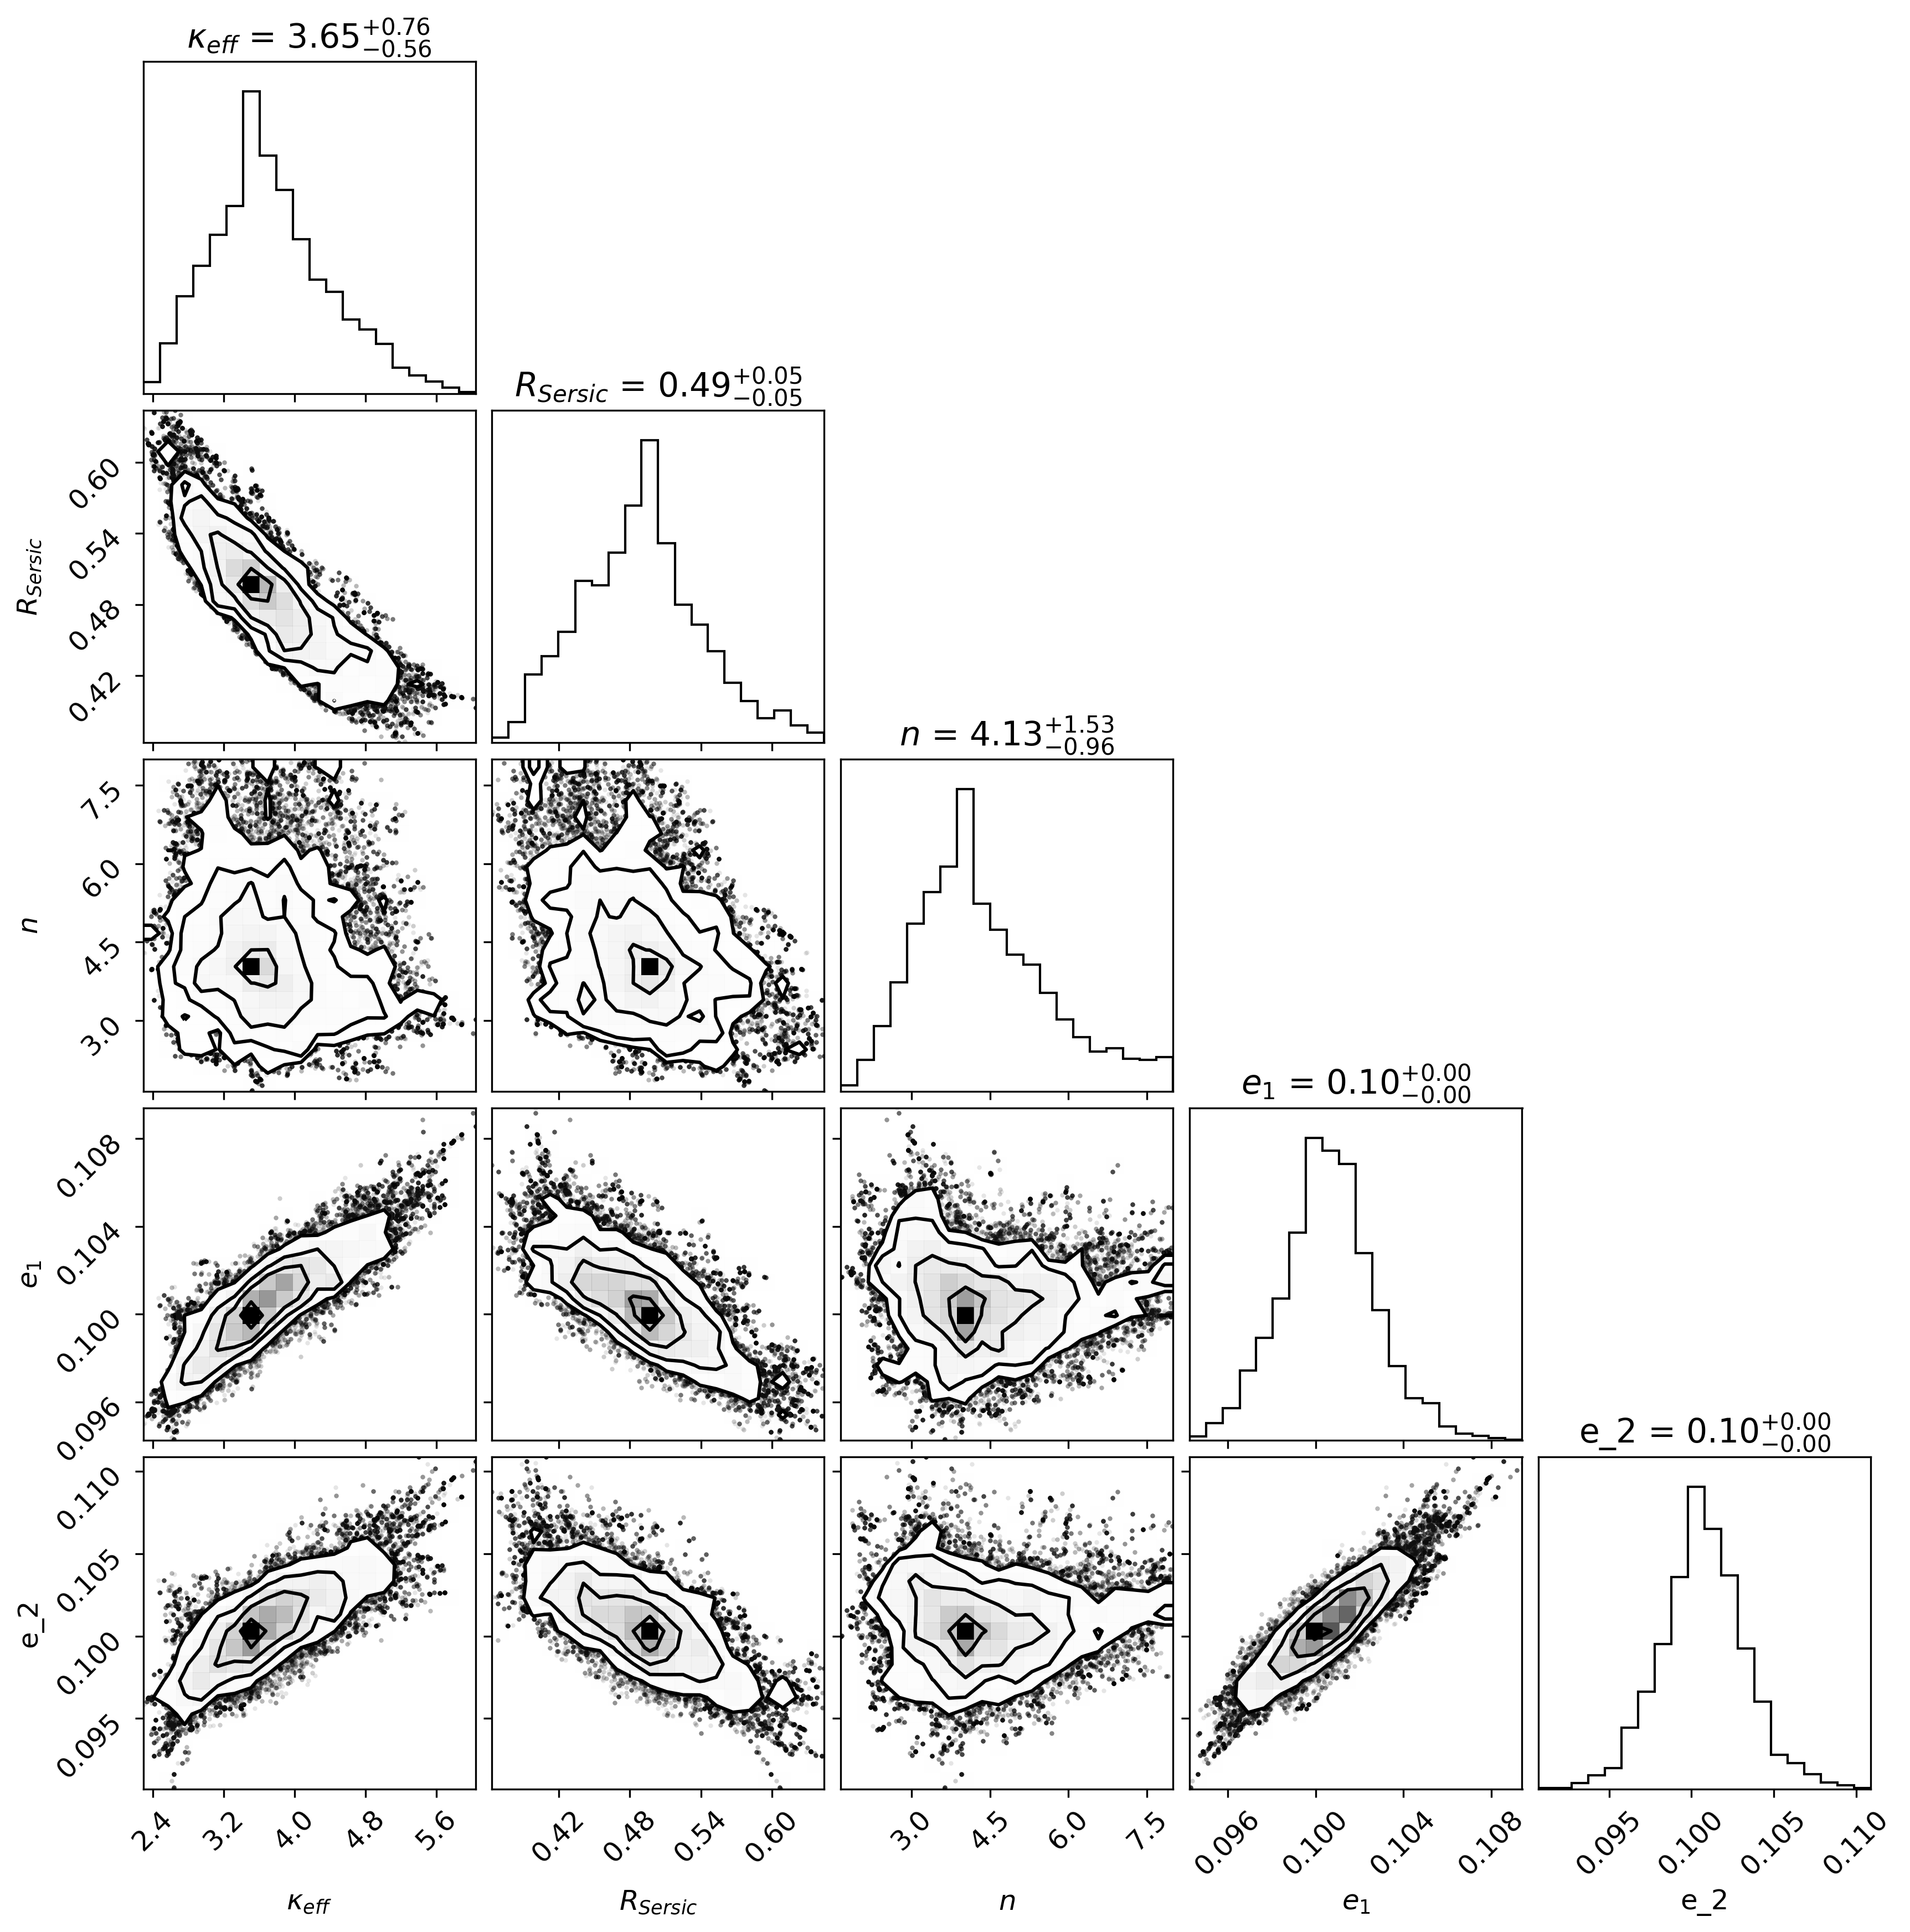

In [115]:
lmfit.report_fit(res.params)
import corner
emcee_corner = corner.corner(res.flatchain,show_titles=True,labels=[
r"$\kappa_{eff}$",
r"$R_{Sersic}$",
r"$n$",
r"$e_1$", r"e_2"], truths=list(res.params.valuesdict().values()))

Para la masa

[[Variables]]
    m:         1.01806792 +/- 0.12802682 (12.58%) (init = 1)
    R_sersic:  0.53299866 +/- 0.25541137 (47.92%) (init = 0.5)
    n_sersic:  4.69128840 +/- 2.07240670 (44.18%) (init = 4)
    e1:        0.09947042 +/- 0.00819148 (8.24%) (init = 0.1)
    e2:        0.09938863 +/- 0.00937949 (9.44%) (init = 0.1)
    center_x:  0 (fixed)
    center_y:  0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(e1, e2)       = +0.9930
    C(R_sersic, e1) = -0.9069
    C(m, R_sersic)  = +0.9005
    C(R_sersic, e2) = -0.8994
    C(m, e1)        = -0.8472
    C(m, e2)        = -0.8328
    C(m, n_sersic)  = +0.4775
    C(n_sersic, e1) = -0.1114


ValueError: Provided figure has 25 axes, but data has dimensions K=7

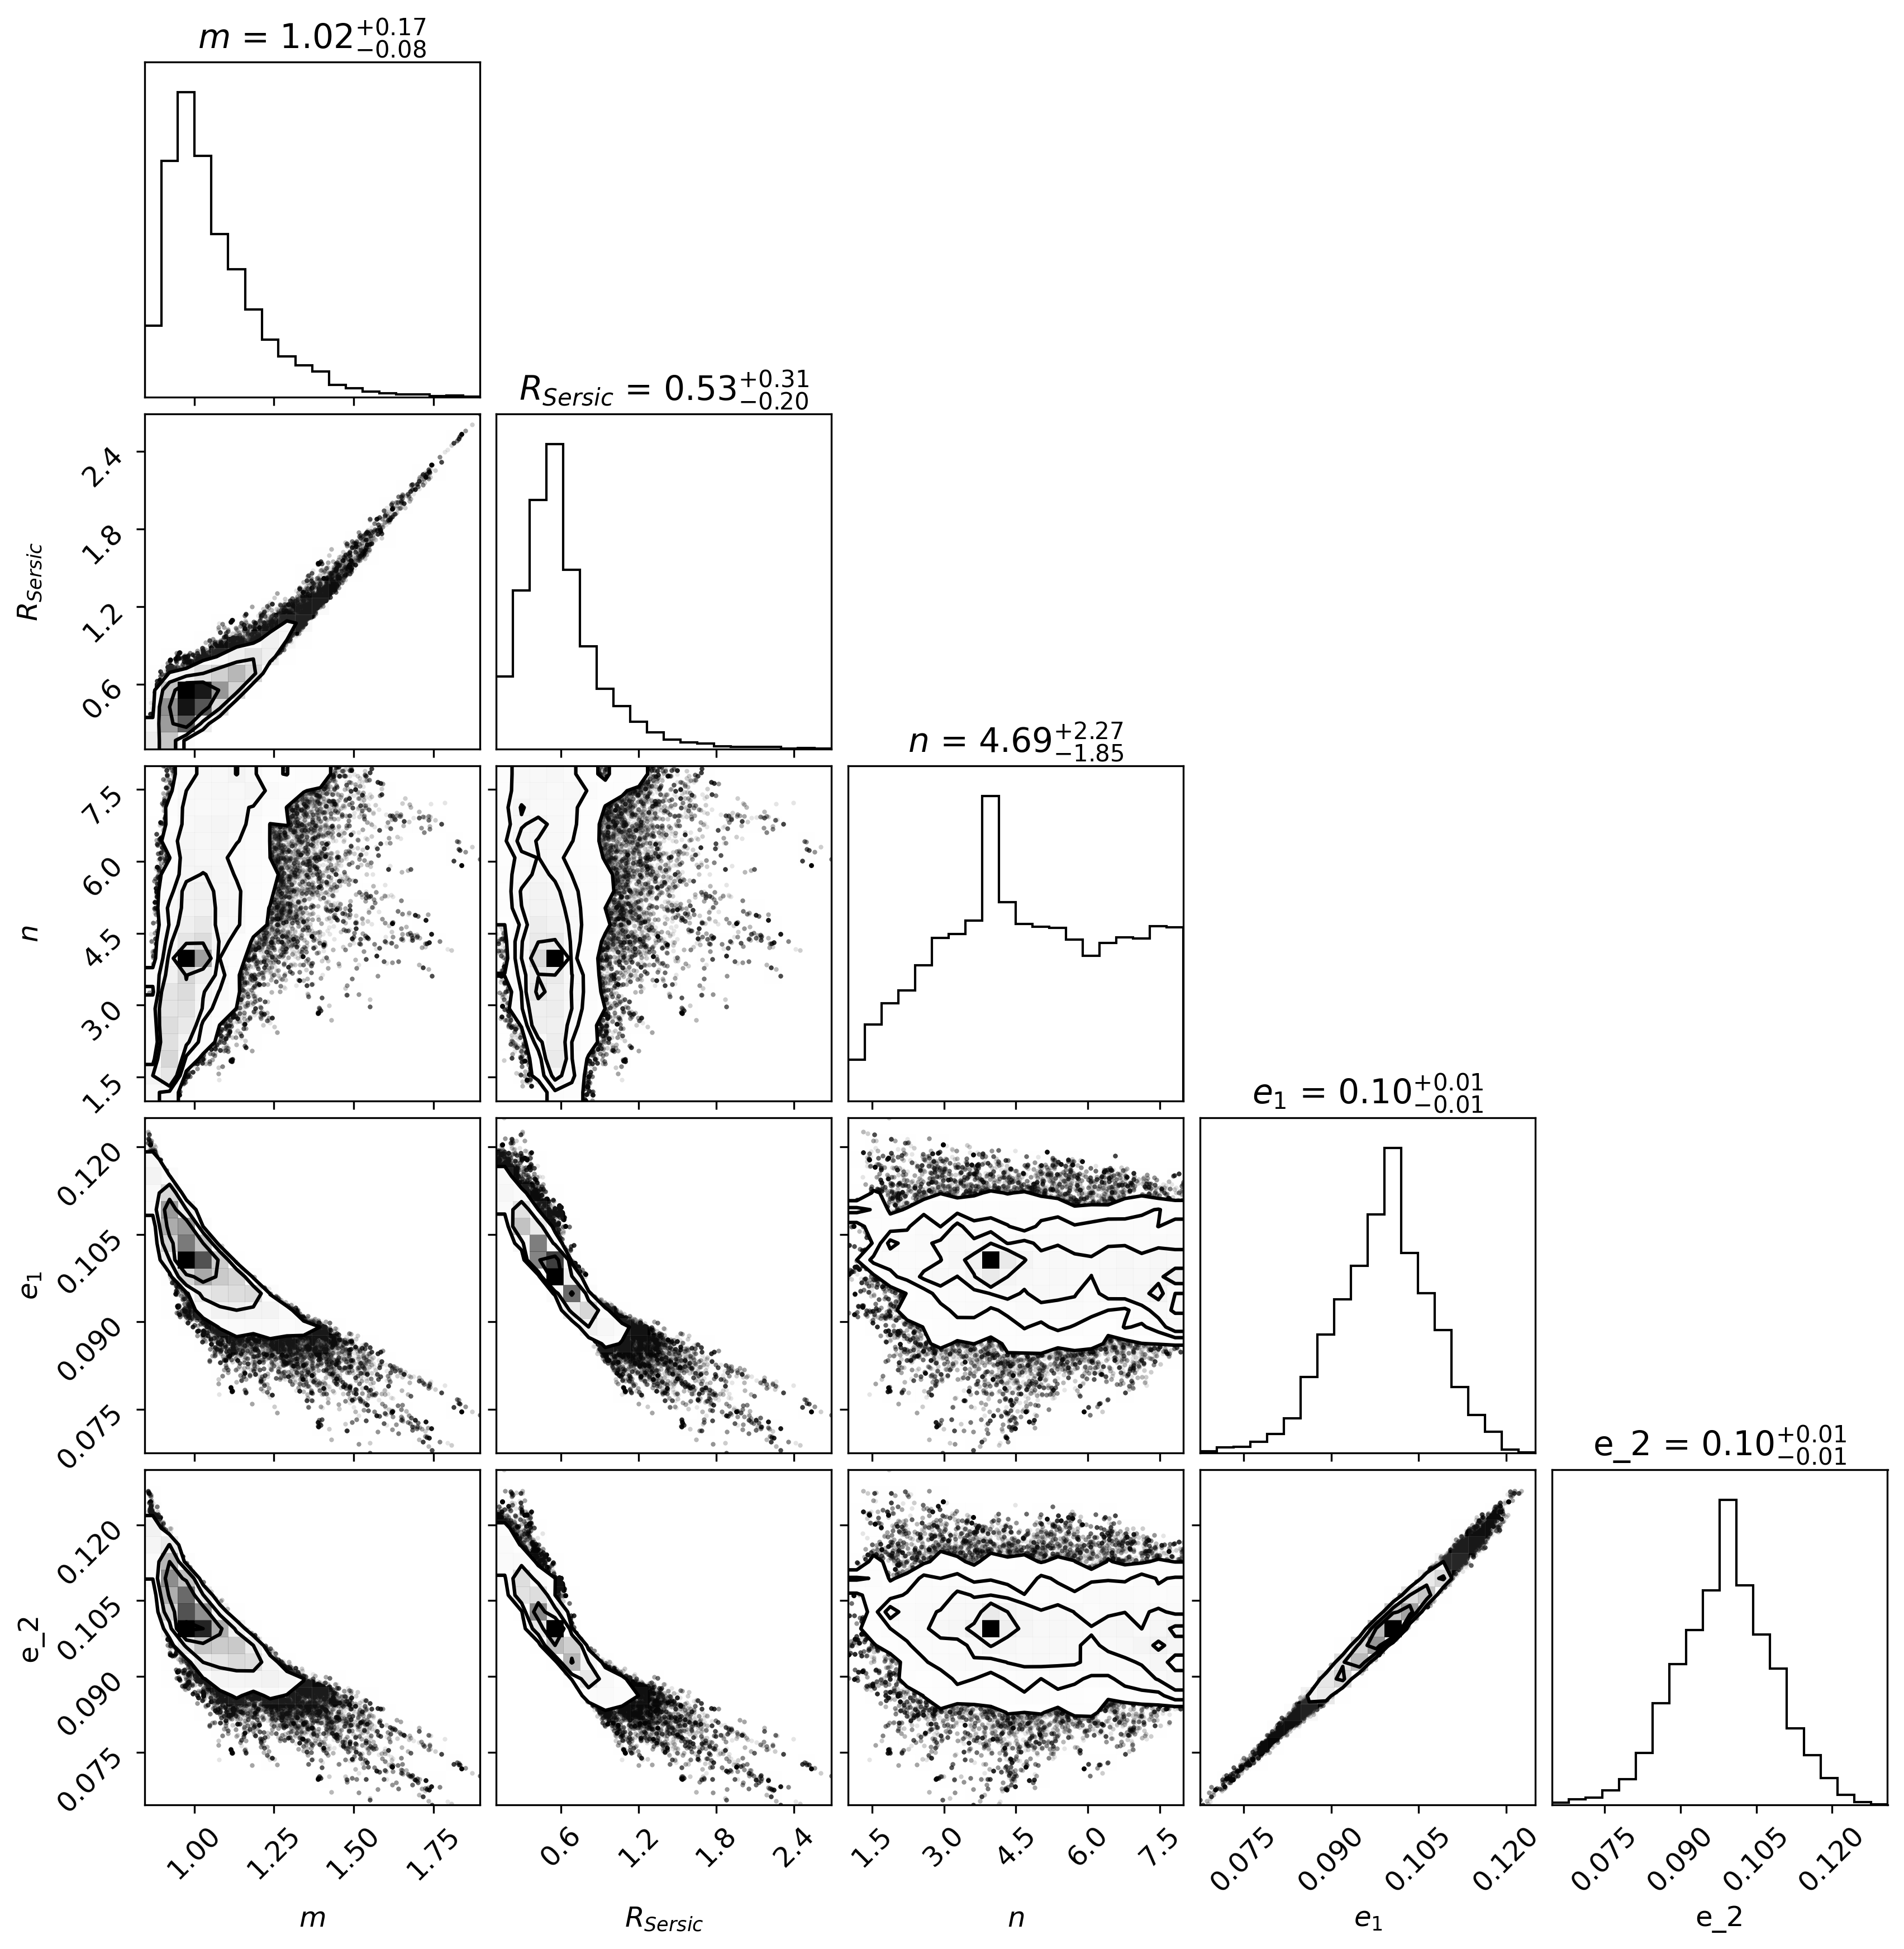

In [117]:
lmfit.report_fit(res2.params)
emcee_corner = corner.corner(res2.flatchain,show_titles=True,labels=[
r"$m$",
r"$R_{Sersic}$",
r"$n$",
r"$e_1$", r"e_2"], truths=list(res2.params.valuesdict().values()))

### 2.5 Graficamos el paso inicial y el resultado final

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


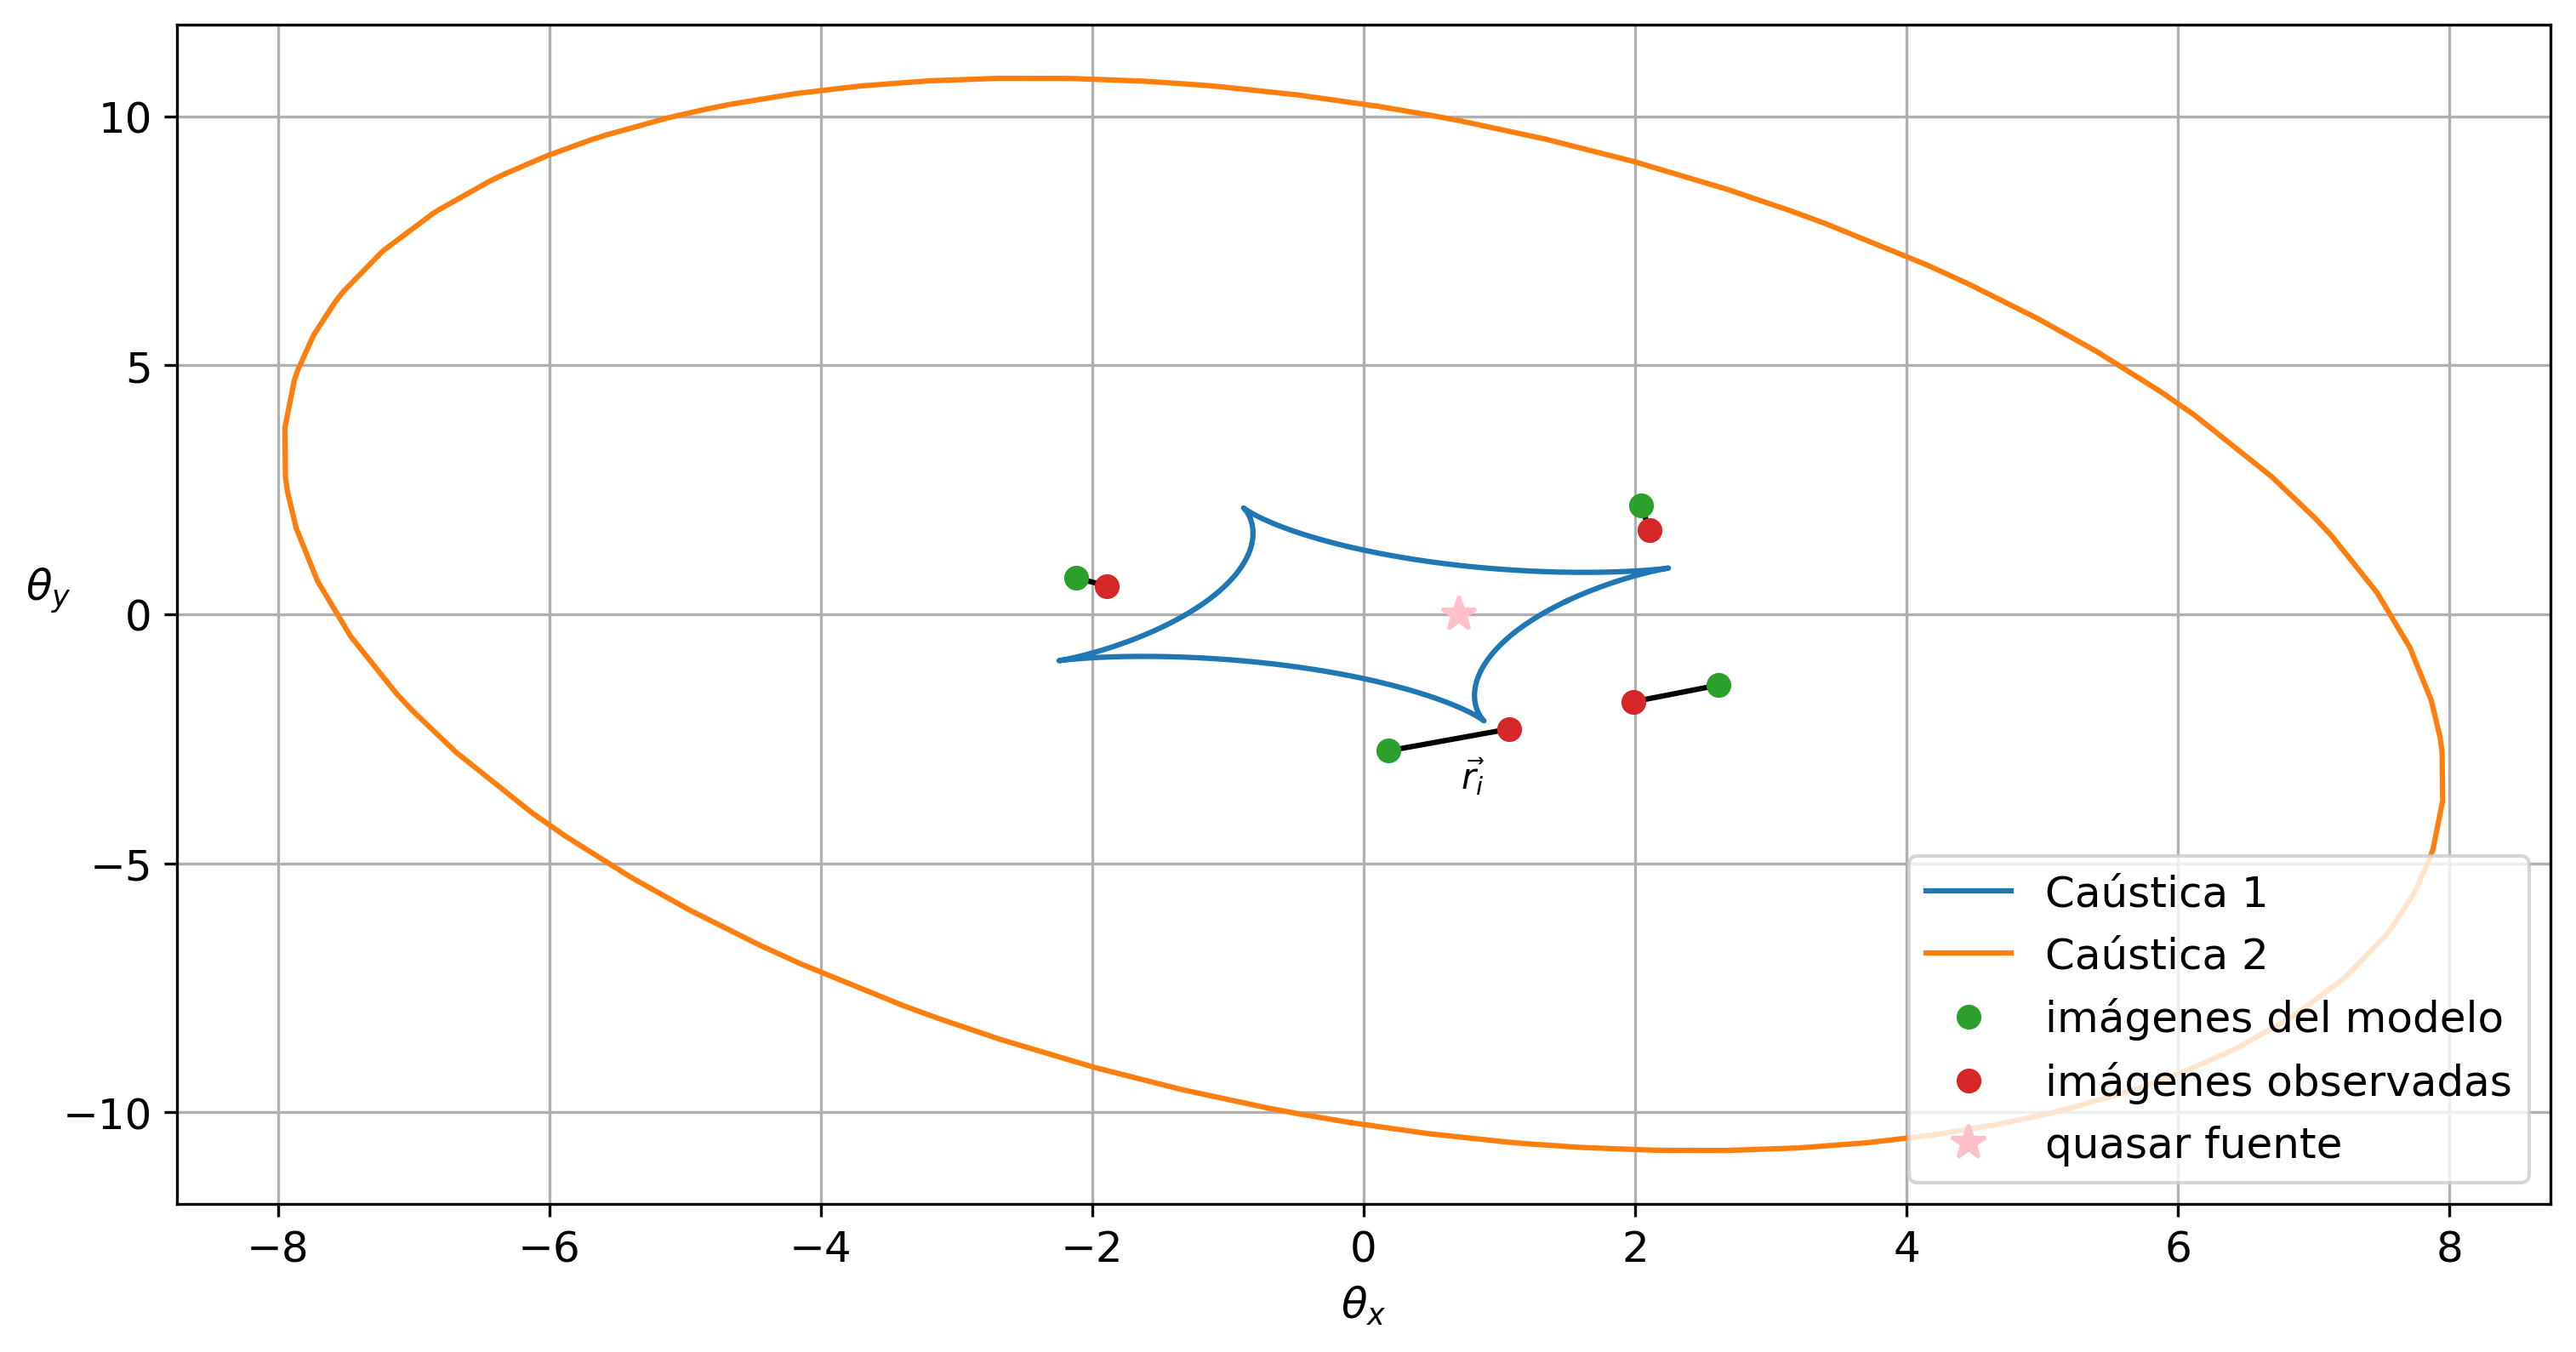

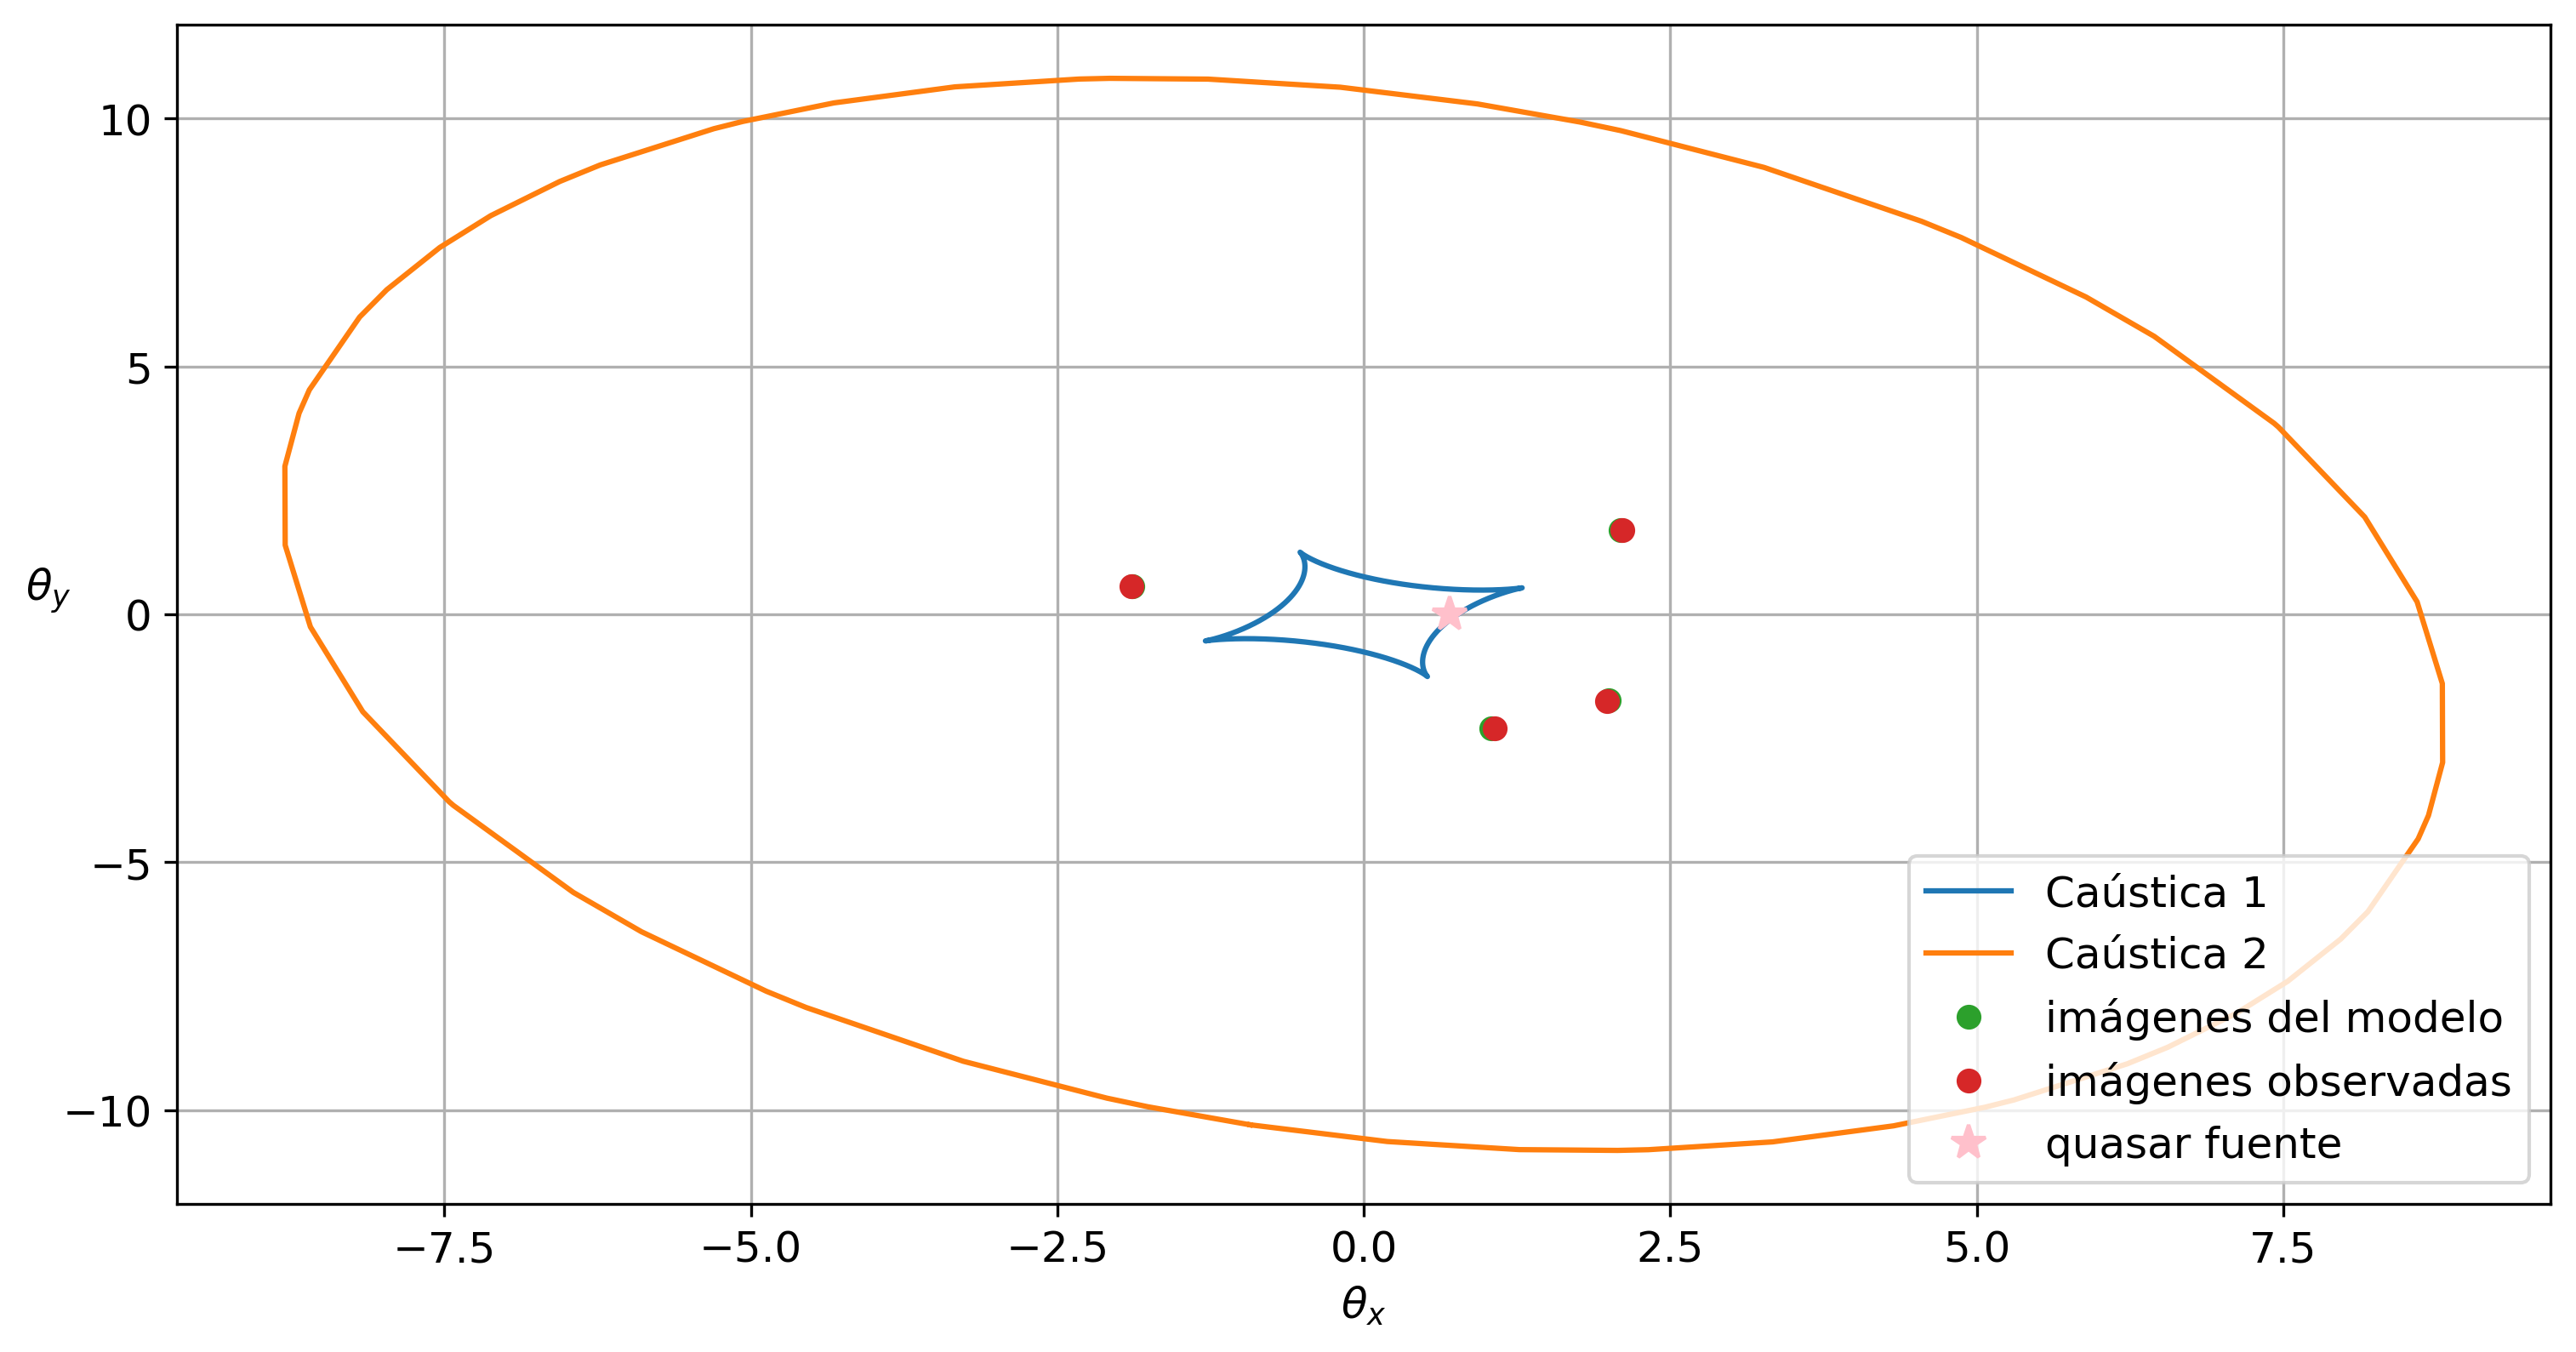

In [13]:
k_eff=3.3
R_sersic=0.6
n_sersic=3.7
kwargs = [{"k_eff": k_eff,'R_sersic':R_sersic,'n_sersic':n_sersic,
"center_x": 0,
"center_y":0,'e1':0.15,'e2':0.15}]
lensext=LensModelExtensions(lens_model_class)
lensEquationSolver = LensEquationSolver(lens_model_class)
#Obtenemos caústicas
criticalra,criticalde,causticsra,causticsd=lensext.critical_curve_caustics(kwargs,compute_window=30)

fig,ax=plt.subplots(1,1,figsize=(12,6))
plt.legend(loc='lower right')
plt.xlabel(r'$\theta_x$')
plt.ylabel(r'$\theta_y$',rotation=0)
x_image, y_image = lensEquationSolver.image_position_from_source(ra_source,dec_source,
                                                                 kwargs, min_distance=deltaPix,
search_window=numPix * deltaPix,
precision_limit=1e-10, num_iter_max=100,
arrival_time_sort=True,
initial_guess_cut=True,
verbose=False,
x_center=0,
y_center=0,
num_random=0,
non_linear=False,
magnification_limit=None)
y_ima=[]
for i in range(len(x2_ima)):
    y_image[i]=-y_image[i]
    y_ima.append(-x2_ima[i])
for i in range(len(x2_ima)):
    plt.plot([x1_ima[i],x_image[i]],[y_ima[i],y_image[i]],color='black')
for i in range(len(causticsra)):
    plt.plot(causticsra[i], causticsd[i], label=f'Caústica {i+1}')
plt.plot(x_image,y_image,'.',markersize=12,label='imágenes del modelo')
plt.plot(x1_ima,y_ima,'.',markersize=12,label='imágenes observadas')
plt.plot(ra_source,dec_source,'*',color='pink',
         markersize=10,label='quasar fuente')
plt.legend(loc='lower right')
plt.text(0.715, -3.5, r'$\vec{r_i}$', fontsize = 10)
plt.grid(True)
plt.show()


# Paso final
k_eff=3.65001936
R_sersic=0.48979753
n_sersic=4.13116007 
kwargs = [{"k_eff": k_eff,'R_sersic':R_sersic,'n_sersic':n_sersic,
"center_x": 0,
"center_y":0,'e1':0.101,'e2':0.101}]
lensext=LensModelExtensions(lens_model_class)
lensEquationSolver = LensEquationSolver(lens_model_class)
criticalra,criticalde,causticsra,causticsd=lensext.critical_curve_caustics(kwargs,compute_window=30)

fig,ax=plt.subplots(1,1,figsize=(12,6))
plt.xlabel(r'$\theta_x$')
plt.ylabel(r'$\theta_y$',rotation=0)
x_image, y_image = lensEquationSolver.image_position_from_source(ra_source,dec_source,kwargs, min_distance=deltaPix,
search_window=numPix * deltaPix,
precision_limit=1e-10, num_iter_max=100,
arrival_time_sort=True,
initial_guess_cut=True,
verbose=False,
x_center=0,
y_center=0,
num_random=0,
non_linear=False,
magnification_limit=None)
for i in range(len(x2_ima)):
   y_image[i]=-y_image[i]
for i in range(len(causticsra)):
    plt.plot(causticsra[i], causticsd[i], label=f'Caústica {i+1}')
plt.plot(x_image,y_image,'.',markersize=12,label='imágenes del modelo')
plt.plot(x1_ima,y_ima,'.',
         markersize=12,label='imágenes observadas')
plt.plot(ra_source,dec_source,'*',
         color='pink',markersize=10,label='quasar fuente')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()